## AI Vision Light
This Notebook, trains a neural network to predict the state of a wifi light, and turn on/off so that the user does not need to manually switch off/on. \
The data to train the network was manually collected ~(66 video sequences splited as 50 train, 16 test), is not very big/diverse, so it does not work for other usecases that are not within my home. 
The notebook is structured: 
- Read the videos from memory
- Understand and visualize the targets (0, 1 of the light status)
- (Data Engineering) Generate the features for the ai model. (Sequences of frames from the videos, with light states)
- Train the model and find the best parameters

In [1]:
import numpy as np
import os 
import json
import matplotlib.pyplot as plt
import copy 
import time 
import math
from IPython.display import clear_output
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import v2 as transforms

In [2]:
FRAME_SEQ_SIZE = 20
FRAME_DELAY = 1
SEQ_STRIDE = 2
BATCH_SIZE = 16

In [3]:
def read_videos(folder: str): 
    all_data = []
    all_targets = []
    files = os.listdir(folder)
    for frame_file in files: 
        compressed = np.load(f"{folder}/{frame_file}")
        frames = compressed['frames']
        metadata = json.loads(compressed['metadata'].tolist())
        
        _raw_targets = np.array([int(m["light_information"]["on"]) for m in metadata])
        all_data.append(frames)
        all_targets.append(_raw_targets)
    return all_data, all_targets

In [4]:
train_data, train_targets = read_videos("./data")
test_data, test_targets = read_videos("./test_data")
len(train_data), len(test_data)

(50, 16)

### Data visualization
We want to understand our videos, and answer this questions: 
- How often there are changes in light status in our data? 
- At what time of the videos there are usually changes?

In [34]:
changes = []
for i in range(len(train_data)): 
    n_changes = 0
    for j in range(1, train_targets[i].shape[0]): 
        if int(train_targets[i][j - 1] != train_targets[i][j]): 
            n_changes += 1
    changes.append(n_changes)

changes = np.array(changes)
print(f"Mean of changes per video: {changes.mean()}, variance of changes per video: {changes.var()}")

Mean of changes per video: 2.04, variance of changes per video: 0.6384000000000001


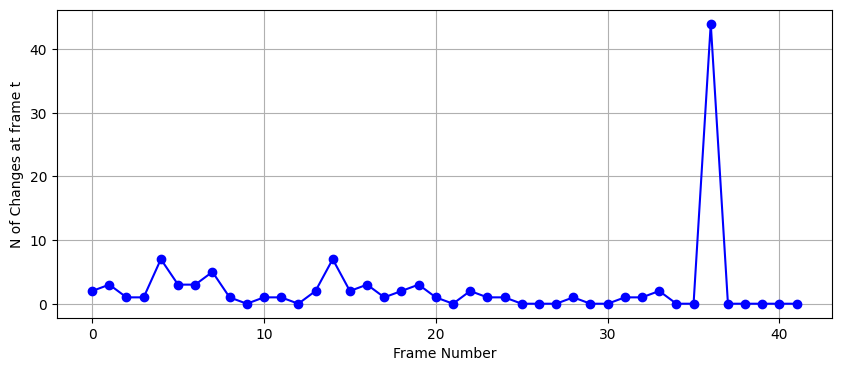

In [35]:
max_video_length = max(len(video) for video in train_data)
changes_frequencies = np.zeros(max_video_length)
for i in range(len(train_data)): 
    changes = np.zeros(max_video_length)
    for j in range(1, train_targets[i].shape[0]): 
        change = int(train_targets[i][j - 1] != train_targets[i][j])
        changes[j-1] = change
    changes_frequencies += changes

plt.figure(figsize=(10, 4))
plt.plot(range(0, max_video_length), changes_frequencies, marker='o', linestyle='-', color='b')
plt.xlabel('Frame Number')
plt.ylabel('N of Changes at frame t')
plt.grid(True)
plt.show()

Becuase of how the data was generated, we have most of the changes ocurring at frame FRAME_SEQ - 5

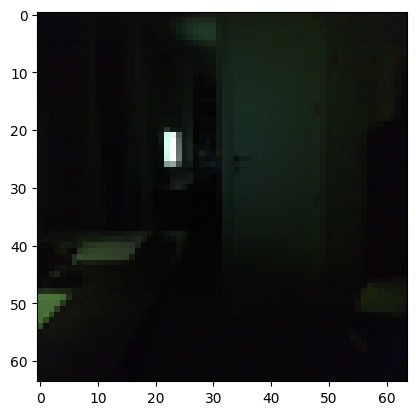

0


In [36]:
# visualize the video 
def visualize_video(video, targets): 
    plt.figure(figsize=(4, 4))
    for frame, target in zip(video, targets): 
        clear_output()
        plt.imshow(frame.transpose(1, 2, 0))
        plt.show()
        print(target)
        time.sleep(0.1)

visualize_video(test_data[-1], test_targets[-1])

### Data engineering
Our goal is to predict the light status at time t + delay, for doing that we get t_n, t_n-1, ..., t_(n-seq_size) frames. \
we apply the delay, because our main goal is to be ahead of the user, if he is walking towards the door, we want to be smarter and turn the light even faster.

In [37]:
def get_delayed_targets(targets): 
    result = []
    n_targets = len(targets) 
    for i in range(n_targets): 
        result.append(
            targets[i + FRAME_DELAY] if i + FRAME_DELAY < n_targets
            else
            targets[i]
        )
    return result 

def detect_change(targets, i: int, _range: int = 3) -> bool: 
    return (
        i > FRAME_SEQ_SIZE 
        and 
        any(i > j and targets[i] != targets[i - j] for j in range(1, _range)) 
    )

In [94]:
def get_lookback_sequences(
    frame_seq, 
    delayed_targets, 
    i, 
    seq_size, 
    n_sequences
):
    if i <= seq_size: 
        return [], []
        
    X_seq_list = []
    y_list = []
    
    lookback_window = min(30, i)  # Look back up to 30 frames or less if not available
    
    for _ in range(n_sequences):
        # Calculate decay weights based on distance from current frame i
        weights = []
        for t in range(1, lookback_window + 1):
            # Exponential decay: probability decreases as t increases
            weight = math.exp(-0.1 * t)  # Adjust the decay rate (0.1) as needed
            weights.append(weight)
        
        # Normalize weights to form a probability distribution
        total_weight = sum(weights)
        norm_weights = [w/total_weight for w in weights]
        
        # Sample the start position based on the probability distribution
        # The closer to the current position, the higher the probability
        positions = list(range(i - lookback_window, i))
        start = random.choices(positions, weights=norm_weights, k=1)[0]
        
        # Ensure we have enough frames for a full sequence
        if start + seq_size <= i:
            X_seq = frame_seq[start:start + FRAME_SEQ_SIZE]
            target = delayed_targets[i]
            X_seq_list.append(X_seq)
            y_list.append(target)
    
    return X_seq_list, y_list

def data_engineering(data, targets, seq_stride: int, n_change_sequences: int = 5, n_normal_sequences: int = 2):
    X = []
    y = []
    
    for frame_seq, targets_seq in zip(data, targets): 
        delayed_targets = get_delayed_targets(targets_seq)
        # detect changes in the targets and create sequences for the change positions.
        for i in range(0, len(frame_seq)): 
            # Check if current target is different from either the previous or the one before that
            if detect_change(delayed_targets, i): 
                X_seq_list, y_list = get_lookback_sequences(
                    frame_seq, delayed_targets, i, FRAME_SEQ_SIZE, n_change_sequences
                )
                X.extend(X_seq_list)
                y.extend(y_list)
    
    for frame_seq, targets_seq in zip(data, targets): 
        delayed_targets = get_delayed_targets(targets_seq)
        for i in range(0, len(frame_seq), seq_stride): 
            X_seq_list, y_list = get_lookback_sequences(
                frame_seq, delayed_targets, i, FRAME_SEQ_SIZE, n_normal_sequences
            )
            X.extend(X_seq_list)
            y.extend(y_list)

    return np.array(X), np.array(y)

In [95]:
X_train, y_train = data_engineering(train_data, train_targets, 1)
X_test, y_test = data_engineering(test_data, test_targets, 1)
X_train.shape, X_test.shape

((1525, 20, 3, 64, 64), (567, 20, 3, 64, 64))

In [71]:
def augment_seq(seq): 
    transform = transforms.Compose([
        transforms.RandomRotation(10), 
        transforms.RandomCrop(size=(50, 50)),
        transforms.Resize(size=(64, 64)),
    ])

    out = transform(seq)
    return out

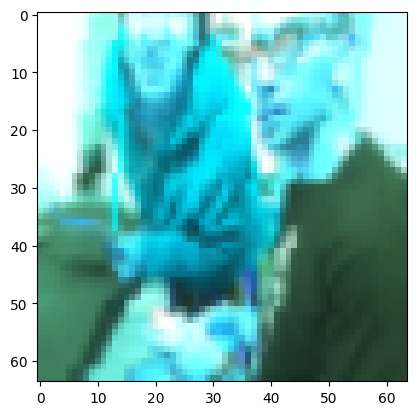

0


In [72]:
visualize_video(augment_seq(torch.Tensor(X_train[0])).numpy().astype(int), [0 for _ in range(X_train[0].shape[0])])

In [73]:
class SeqDataset(Dataset):
    def __init__(self, X, y, augment=False, augment_ratio=0.5):
        super().__init__()
        self.X = X
        self.y = y
        self.mean = np.mean(X)  # Calculate mean for normalization
        self.std = np.std(X)  # Calculate standard deviation for normalization
        self.augment = augment
        self.augment_ratio = augment_ratio
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index: int):
        X_seq = self.X[index]
        X_seq = (X_seq - self.mean) / self.std

        target = self.y[index]

        # Ensure target is a single value, you might need to adjust the slicing based on y's structure
        target = torch.tensor(target).float() # Convert to float tensor
        X_seq = torch.tensor(X_seq).float()
        if self.augment and random.random() < self.augment_ratio: 
            X_seq = augment_seq(X_seq)
        
        assert X_seq.shape[0] == FRAME_SEQ_SIZE
        
        return X_seq, target

### Train the model.
We use a pretrained lightweight CNN model an LSTM to capture time relationships on the frames. \
We test training the model with different augmentation parameters, and pick the model with the best test error.

In [83]:
class VideoCNNLSTM(nn.Module):
    def __init__(
        self, 
        hidden_size=256,
        num_layers=1,
        dropout=0.5,
    ):
        super(VideoCNNLSTM, self).__init__()
        
        # Load pretrained ResNet18
        self.pretrained_model = models.squeezenet1_0(pretrained=True)
        
        # Optionally freeze ResNet weights
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
        
        # Remove the final fully connected layer from ResNet
        # ResNet18 outputs 512 features from its last conv layer
        self.resnet = nn.Sequential(*list(self.pretrained_model.children())[:-1])  # Remove fc layer
        self.resnet.requires_grad = False
        
        # ResNet18 with default stride outputs 512 features
        # After 7x7 input becomes 1x1 (assuming input 224x224)
        self.lstm_input_size = 4608 # ResNet18's feature dimension
        
        # LSTM for temporal processing
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Final classification layer
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        #self.load_state_dict(torch.load("./model.pt"))

    def forward(self, x):
        # x shape: (batch_size, frames, channels, height, width)
        batch_size, frames, channels, height, width = x.size()
        
        # Process each frame with ResNet
        cnn_output = []
        for t in range(frames):
            # Get current frame
            frame = x[:, t, :, :, :]  # (batch_size, channels, height, width)
            
            # Apply ResNet
            frame = self.resnet(frame)  # (batch_size, 512, 1, 1)
            
            # Flatten ResNet output for LSTM
            frame = frame.view(batch_size, -1)  # (batch_size, 512)
            cnn_output.append(frame)
        
        # Stack CNN outputs to create sequence
        cnn_output = torch.stack(cnn_output, dim=1)  # (batch_size, frames, 512)
        
        # Feed sequence to LSTM
        lstm_out, _ = self.lstm(cnn_output)
        
        # Use final time step output for classification
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Apply dropout and final classification
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        output = output.relu()
        output = self.fc2(output)
        
        return output

In [86]:
def evaluate(model, test_loader, mode = "test"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze(1)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += inputs.shape[0]
    
    return 100 * correct / total

def train(model, train_loader, test_loader, criterion, optimizer, epochs=5, model_name: str = "model.pt"):
    model.train()
    train_losses = []
    test_accuracies = []
    best_test_acc = 0
    for epoch in range(epochs): 
        epoch_loss = 0
        for i, (inputs, labels) in enumerate(train_loader): 
            optimizer.zero_grad()

            outputs = model(inputs) 
            loss = criterion(outputs.squeeze(1), labels) 
            epoch_loss += loss.item()
            print(f"Epoch: {epoch + 1}, step: {i}/{len(train_loader)}, loss: {epoch_loss / (i + 1)}", end="\r")

            loss.backward()
            optimizer.step()
        test_acc = evaluate(model, test_loader)
        print("")
        print(f"Epoch: {epoch + 1}/{epochs}, test accuracy: {test_acc}", end="\r")
        print("")

        # Save the model weights if this is a new best test accuracy. 
        if test_acc > best_test_acc: 
            best_test_acc = test_acc
            torch.save(model.state_dict(), f"./models/{model_name}.pt")
        train_losses.append(epoch_loss / len(train_loader))
        test_accuracies.append(test_acc)
    return train_losses, test_accuracies

In [99]:
def run_training_pipeline(
    model, 
    learning_rate: int, 
    name: str, 
    epochs: int = 6, 
    n_lookback_changes: int = 5,
    n_lookback_normal: int = 1, 
    seq_stride: int = SEQ_STRIDE, 
): 
    X_train, y_train = data_engineering(train_data, train_targets, seq_stride, n_lookback_changes, n_lookback_normal)
    X_test, y_test = data_engineering(test_data, test_targets, seq_stride, 2, 1)
    
    train_dataset = SeqDataset(X_train, y_train, augment=True, augment_ratio=0.5)
    test_dataset = SeqDataset(X_test, y_test, augment=False)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_accuracies = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=epochs, model_name=name)

    # Plotting the results
    plt.figure(figsize=(12, 5))

    # Plot training losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracies
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy', color='green')
    plt.title('Test Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch: 1/6, test accuracy: 62.02531645569629065
Epoch: 2/6, test accuracy: 64.55696202531645104
Epoch: 3/6, test accuracy: 65.18987341772151379
Epoch: 4/6, test accuracy: 65.18987341772151148
Epoch: 5/6, test accuracy: 70.25316455696202047
Epoch: 6/6, test accuracy: 65.82278481012658599


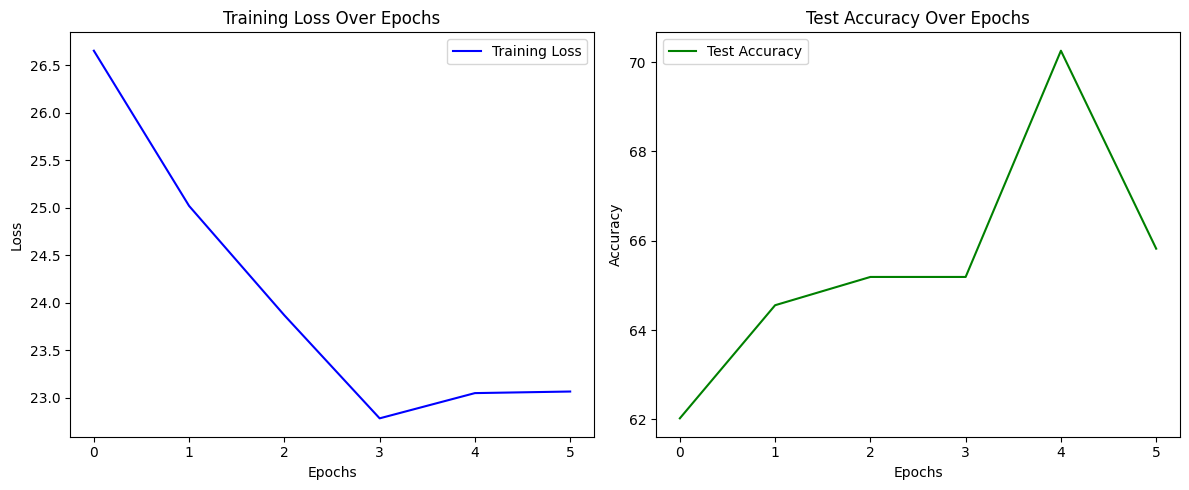

In [100]:
model = VideoCNNLSTM()
run_training_pipeline(
    model, 
    learning_rate=0.001, 
    epochs=6, 
    name="model_5_1", 
    n_lookback_changes=5, 
    n_lookback_normal=1,
    seq_stride=2, 
)

Epoch: 1/6, test accuracy: 47.8431372549019634048
Epoch: 2/6, test accuracy: 54.9019607843137253448
Epoch: 3/6, test accuracy: 56.8627450980392140453
Epoch: 4/6, test accuracy: 61.1764705882353641961
Epoch: 5/6, test accuracy: 57.2549019607843165626
Epoch: 6/6, test accuracy: 53.7254901960784349852


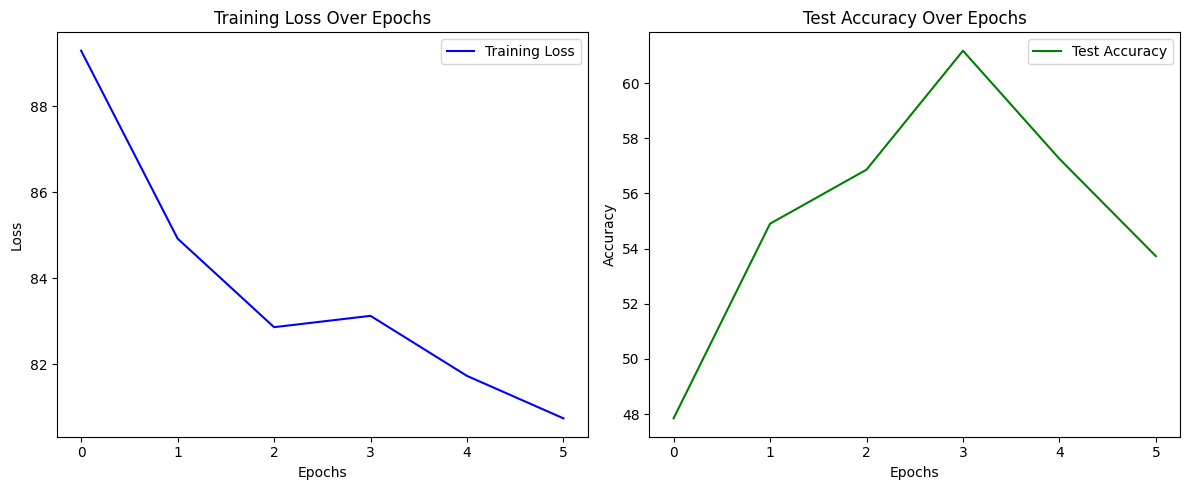

In [101]:
model = VideoCNNLSTM()
run_training_pipeline(
    model, 
    learning_rate=0.001, 
    epochs=6, 
    name="model_5_3", 
    n_lookback_changes=5, 
    n_lookback_normal=3,
    seq_stride=1, 
)

In [ ]:
model = VideoCNNLSTM()
run_training_pipeline(
    model, 
    learning_rate=0.001, 
    epochs=6, 
    name="model_7_5.pt", 
    n_lookback_changes=7, 
    n_lookback_normal=5, 
    seq_stride=1, 
)

Epoch: 1/6, test accuracy: 55.2123552123552163927
Epoch: 2/6, test accuracy: 57.9150579150579156116
